In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np

from model_SARIMA import find_SARIMA, build_SARIMA, SARIMA_for_all_stores
from model_naiv import build_naive_model, naive_for_all_stores

from test_mean import t_test, wilcoxon_test, binomial_test, kolmogorov_test
from test_correlation import residual_plot, acf_resid_plot, box_pierce_test, ljung_box_test, durbin_watson_test, breusch_godfrey_test, run_test
from test_normal import hist_plot

from cross_validation import cross_validation_all_stores

warnings.filterwarnings("ignore")

/Users/alex/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Datensatz lesen

In [2]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

Alle Residuen und Fitted Values berechnen

In [ ]:
#residuals_dict = naive_for_all_stores('Walmart_Sales.csv')

fitted_values_dict = {}
residuals_dict = {}

sarima_models = SARIMA_for_all_stores('Walmart_Sales.csv')
for store in range(1, 46):
    model = sarima_models.get(store)
    
    fitted_values_dict[store] = model.fittedvalues.iloc[1:] # remove first value because it is 0
    residuals_dict[store] = model.resid.iloc[1:] # remove first value because it is 0


Store 1: Modell erstellt mit Order (1, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 2: Modell erstellt mit Order (4, 0, 3) und Seasonal Order (1, 0, 1, 52)
Store 3: Modell erstellt mit Order (1, 1, 1) und Seasonal Order (2, 0, 0, 52)
Store 4: Modell erstellt mit Order (2, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 5: Modell erstellt mit Order (1, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 6: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 7: Modell erstellt mit Order (0, 1, 1) und Seasonal Order (0, 1, 0, 52)
Store 8: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 9: Modell erstellt mit Order (1, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 10: Modell erstellt mit Order (4, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 11: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 12: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 13: Modell erstellt mit Order (2, 0, 2) und Seasonal Or

Residuen

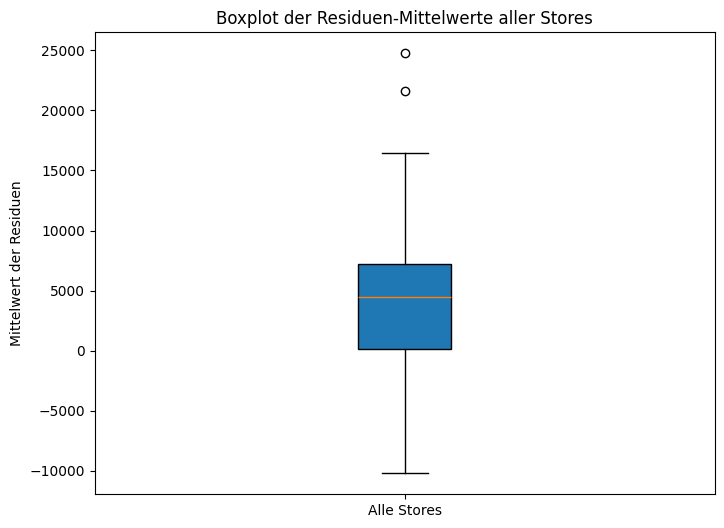

In [4]:
store_means = []
for store in sorted(residuals_dict.keys(), key=int):
    # residuals_dict[store] ist eine pandas Series
    mean_resid = residuals_dict[store].mean()
    store_means.append(mean_resid)

# Erstelle den Boxplot der Mittelwerte
plt.figure(figsize=(8, 6))
plt.boxplot(store_means, patch_artist=True)
plt.title("Boxplot der Residuen-Mittelwerte aller Stores")
plt.ylabel("Mittelwert der Residuen")
plt.xticks([1], ["Alle Stores"])
plt.show()

Korrelations Tests

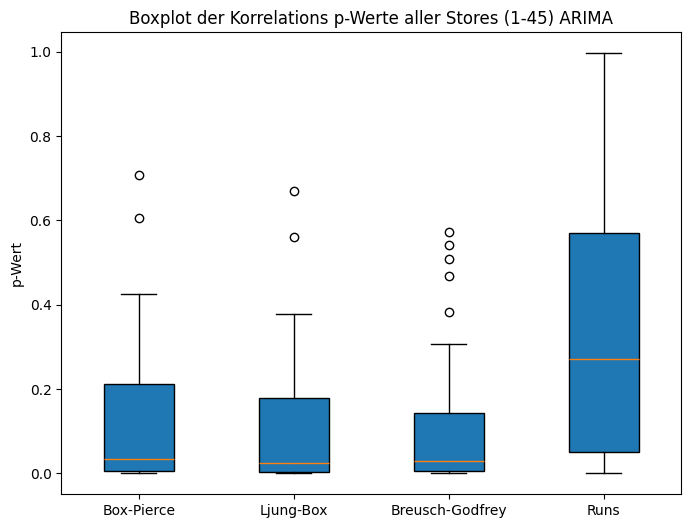

[0.2111703567112632, 0.05122683999087134, 0.08992913541475585, 0.15597645073250804, 0.013105747054213022, 0.022374263894494876, 0.004903396992074174, 0.0042678189300681645, 0.2137508867786738, 0.4156294157545584, 0.010746611031737891, 0.00600728411181688, 0.03004990909582953, 0.3803486930421682, 0.015075305832730007, 0.17519162757355397, 0.3295039507591481, 0.3403428340568878, 0.04982866145092638, 0.050200551119524, 0.005673567166306194, 0.012707288847002661, 0.058189277416609425, 0.06433342562523528, 0.707187801846763, 0.07312152500150529, 0.0327217546065745, 0.0029092240638685487, 0.0033351309507682306, 3.4038008993178145e-08, 0.39012665167583155, 0.01737971936106465, 1.961826721423384e-10, 0.02638948332246661, 0.363147394459397, 3.664789127999678e-14, 0.0017868353362156992, 0.4262160803020156, 0.2909395179707483, 0.022495634174185434, 0.6044607366940205, 3.149150168337888e-07, 2.9939283391179713e-07, 0.0009015742447476383, 0.04193022722166608]


In [5]:
bp_pvalues = []
lb_pvalues = []
bg_pvalues = []
rt_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        # Box-Pierce Test
        try:
            _, p_value = box_pierce_test(resid, lags=[10])
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
        # Ljung-Box Test
        try:
            _, p_value = ljung_box_test(resid, lags=[10])
            lb_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Ljung-Box Test für Store {store}: {e}")
            lb_pvalues.append(np.nan)
        # Breusch-Godfrey Test
        try:
            _, p_value = breusch_godfrey_test(resid, lags=10)
            bg_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Breusch-Godfrey Test für Store {store}: {e}")
            bg_pvalues.append(np.nan)
        # Runs Test
        try:
            _, p_value = run_test(resid)
            rt_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Runs Test für Store {store}: {e}")
            rt_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)
        lb_pvalues.append(np.nan)
        bg_pvalues.append(np.nan)
        rt_pvalues.append(np.nan)


pvalues = np.column_stack([bp_pvalues, lb_pvalues, bg_pvalues, rt_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True)
plt.title("Boxplot der Korrelations p-Werte aller Stores (1-45) ARIMA")
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4], ["Box-Pierce", "Ljung-Box", "Breusch-Godfrey", "Runs"])
plt.show()

print(bp_pvalues)

Durbin Watson

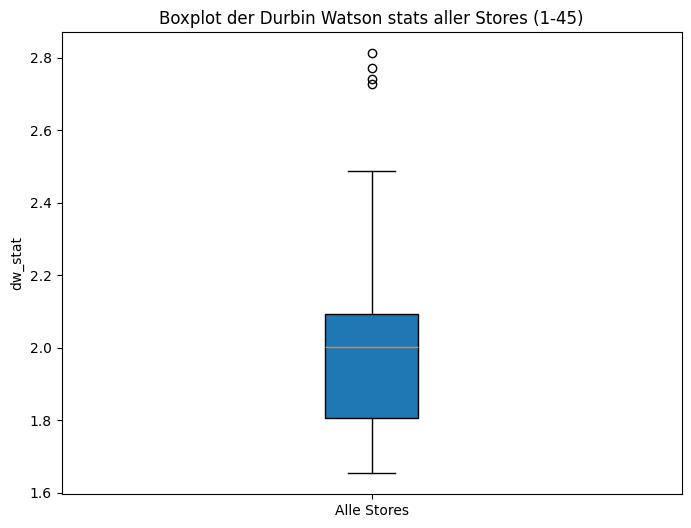

In [6]:
dw_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        try:
            dw_stat = durbin_watson_test(resid)
            dw_stats.append(dw_stat)
        except Exception as e:
            print(f"Fehler beim Durbin Watson Test für Store {store}: {e}")
            dw_stats.append(np.nan)
    else:
        dw_stats.append(np.nan)

# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(dw_stats, patch_artist=True)
plt.title("Boxplot der Durbin Watson stats aller Stores (1-45)")
plt.ylabel("dw_stat")
plt.xticks([1], ["Alle Stores"])
plt.show()


Mittelwert Tests

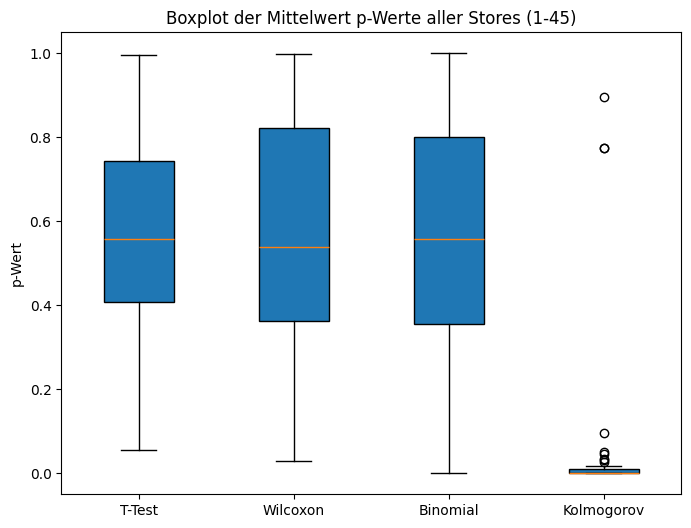

In [7]:
t_pvalues = []
w_pvalues = []
b_pvalues = []
k_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        # T-Test
        try:
            _, p_value = t_test(resid)
            t_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim t-Test für Store {store}: {e}")
            t_pvalues.append(np.nan)
        # Wilcoxon Test
        try:
            _, p_value = wilcoxon_test(resid)
            w_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Wilcoxon Test für Store {store}: {e}")
            w_pvalues.append(np.nan)
        # Binomial Test
        try:
            _, _, p_value = binomial_test(resid)
            b_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Binomial Test für Store {store}: {e}")
            b_pvalues.append(np.nan)
        # Kolmogorov Test
        try:
            _, p_value = kolmogorov_test(resid)
            k_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Kolmogorov Test für Store {store}: {e}")
            k_pvalues.append(np.nan)
    else:
        t_pvalues.append(np.nan)
        w_pvalues.append(np.nan)
        b_pvalues.append(np.nan)
        k_pvalues.append(np.nan)


pvalues = np.column_stack([t_pvalues, w_pvalues, b_pvalues, k_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True)
plt.title("Boxplot der Mittelwert p-Werte aller Stores (1-45)")
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4], ["T-Test", "Wilcoxon", "Binomial", "Kolmogorov"])
plt.show()



Kreuzvalidierung

In [8]:
cvs = cross_validation_all_stores('Walmart_Sales.csv')

Verarbeite Store 1 (Datenlänge: 143)...
Cross-Validation RMSE: 88027.56322355426
Verarbeite Store 2 (Datenlänge: 143)...
Cross-Validation RMSE: 76663.40615303122
Verarbeite Store 3 (Datenlänge: 143)...
Cross-Validation RMSE: 23953.699858389737
Verarbeite Store 4 (Datenlänge: 143)...
Cross-Validation RMSE: 83587.5997765496
Verarbeite Store 5 (Datenlänge: 143)...
Cross-Validation RMSE: 18367.25093480805
Verarbeite Store 6 (Datenlänge: 143)...
Cross-Validation RMSE: 93659.8632397312
Verarbeite Store 7 (Datenlänge: 143)...
Cross-Validation RMSE: 33321.5032649151
Verarbeite Store 8 (Datenlänge: 143)...
Cross-Validation RMSE: 42035.19852552504
Verarbeite Store 9 (Datenlänge: 143)...
Cross-Validation RMSE: 30580.994522736946
Verarbeite Store 10 (Datenlänge: 143)...
Cross-Validation RMSE: 123370.29128464009
Verarbeite Store 11 (Datenlänge: 143)...
Cross-Validation RMSE: 81880.48169253494
Verarbeite Store 12 (Datenlänge: 143)...
Cross-Validation RMSE: 53539.17702939983
Verarbeite Store 13 (Date

Korrelations Test

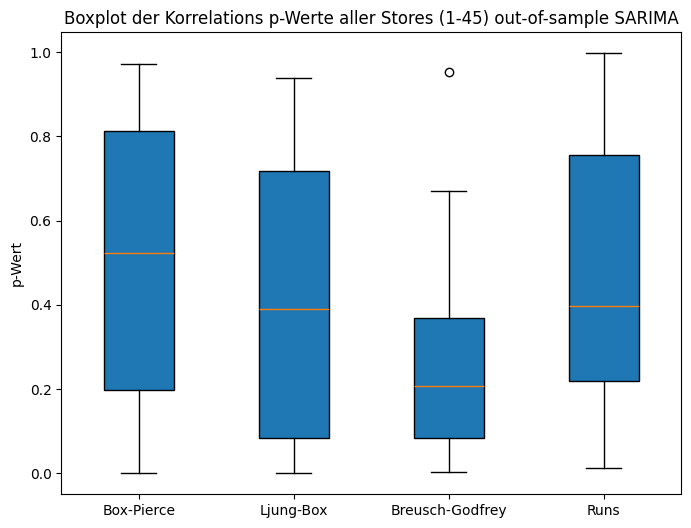

[0.03517803422519247, 0.8828351553348935, 0.8135485597857433, 0.842617567131992, 0.1707584832594972, 0.45255652462238394, 0.08119891690296596, 0.5568682733405164, 0.9545045097114585, 0.5365487308654446, 0.5680477956611493, 0.2098193658286281, 0.8036765961865866, 0.18285689407813469, 0.508700628680855, 0.9515095176765802, 0.9714965516521743, 0.7421208571500472, 0.3556949193683708, 0.2596767623275982, 0.9367653471254289, 0.859912629947474, 0.8573767584328519, 0.7312321222450993, 0.1422780011970711, 0.9520913310306353, 0.6770474203978802, 0.0003341464591124644, 0.8067812079828098, 0.5238411955628053, 0.5982104744025368, 0.7950725231286406, 0.04310961977994429, 0.19705950004320774, 0.3052101633504796, 0.0013906352185804618, 0.08264063187780114, 0.13954424770266124, 0.9412440125423365, 0.21985441770032038, 0.874114409589071, 0.49569911580430037, 0.21940159767578388, 0.007909101526421802, 0.4549990648170126]


In [9]:
bp_pvalues = []
lb_pvalues = []
bg_pvalues = []
rt_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    errors = cvs[cvs['store'] == store]['error']
    if errors is not None:
        # Box-Pierce Test
        try:
            _, p_value = box_pierce_test(errors, lags=[10])
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
        # Ljung-Box Test
        try:
            _, p_value = ljung_box_test(errors, lags=[10])
            lb_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Ljung-Box Test für Store {store}: {e}")
            lb_pvalues.append(np.nan)
        # Breusch-Godfrey Test
        try:
            _, p_value = breusch_godfrey_test(errors, lags=10)
            bg_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Breusch-Godfrey Test für Store {store}: {e}")
            bg_pvalues.append(np.nan)
        # Runs Test
        try:
            _, p_value = run_test(errors)
            rt_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Runs Test für Store {store}: {e}")
            rt_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)
        lb_pvalues.append(np.nan)
        bg_pvalues.append(np.nan)
        rt_pvalues.append(np.nan)


pvalues = np.column_stack([bp_pvalues, lb_pvalues, bg_pvalues, rt_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True)
plt.title("Boxplot der Korrelations p-Werte aller Stores (1-45) out-of-sample SARIMA")
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4], ["Box-Pierce", "Ljung-Box", "Breusch-Godfrey", "Runs"])
plt.show()

print(bp_pvalues)

Mittelwert Tests

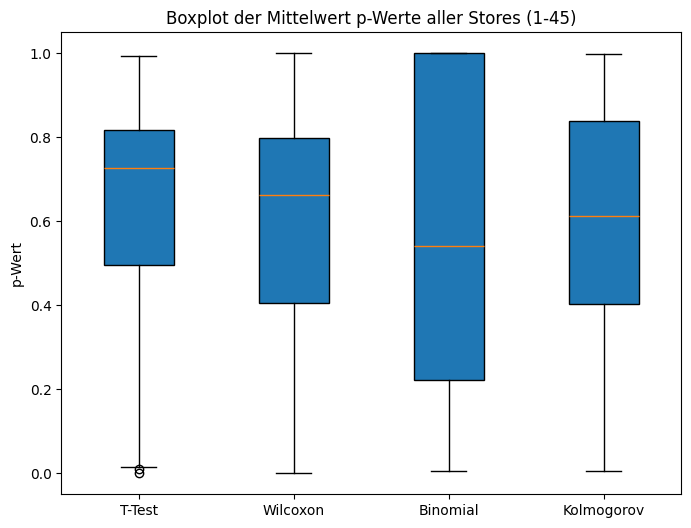

In [10]:
t_pvalues = []
w_pvalues = []
b_pvalues = []
k_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    errors = cvs[cvs['store'] == store]['error']
    if resid is not None:
        # T-Test
        try:
            _, p_value = t_test(errors)
            t_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim t-Test für Store {store}: {e}")
            t_pvalues.append(np.nan)
        # Wilcoxon Test
        try:
            _, p_value = wilcoxon_test(errors)
            w_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Wilcoxon Test für Store {store}: {e}")
            w_pvalues.append(np.nan)
        # Binomial Test
        try:
            _, _, p_value = binomial_test(errors)
            b_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Binomial Test für Store {store}: {e}")
            b_pvalues.append(np.nan)
        # Kolmogorov Test
        try:
            _, p_value = kolmogorov_test(errors)
            k_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Kolmogorov Test für Store {store}: {e}")
            k_pvalues.append(np.nan)
    else:
        t_pvalues.append(np.nan)
        w_pvalues.append(np.nan)
        b_pvalues.append(np.nan)
        k_pvalues.append(np.nan)


pvalues = np.column_stack([t_pvalues, w_pvalues, b_pvalues, k_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True)
plt.title("Boxplot der Mittelwert p-Werte aller Stores (1-45)")
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4], ["T-Test", "Wilcoxon", "Binomial", "Kolmogorov"])
plt.show()

